In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
import cv2
import pandas as pd
import skimage
import re
import glob


plt.style.use('ggplot')

In [2]:
DATASET_DIR="../dataset/LPW_frames/LPW/"

### Algoritmo y Heurística

In [3]:
def sumatorias(image, div=10, debug=0):
    image = ~image
    image = image / image.max() *255
    kernel = np.ones((5,5), np.uint8)  
    image = cv2.erode(image, kernel, iterations=1)  
    ejeX = []
    ejeY = []
    x=0
    y=0
    while(x < len(image)):
        suma = 0
        while(y<len(image[0])):
            valor = image[x,y]
            if(valor > 200):
                suma = suma + valor
            elif(valor < -1):
                suma = suma + 255-valor
            y = y + div
        ejeX.append(suma)
        x = x + div
        y = 0

    while(y < len(image[0])):
        suma = 0
        while(x<len(image)):
            valor = image[x,y]
            if(valor > 200):
                suma = suma + valor
            elif(valor < -1):
                suma = suma + 255-valor
            x = x + div
        ejeY.append(suma)
        y = y + div
        x = 0
    i = 0
    j = 0
    if(debug == 1):
        plt.figure()
        plt.imshow(image,cmap='gray')
        plt.figure()
        plt.plot(ejeX)
        plt.plot(ejeY)
    coordX = ejeY.index(max(ejeY))*div
    coordY = ejeX.index(max(ejeX))*div
    return (coordX, coordY)


In [4]:
def find_pupil(image):
    if peak_detected(image):
        edges = edge_pupil_center_detection(image)
        if (edges is not None):
            ellipsis, center = edges
            return ellipsis, center
        else:
            # Thresholding and coarse positioning
            return None
    else:
        # Thresholding and coarse positioning
        return None


# Returns True if there is a peak in the histogram of an image
def peak_detected(image, th=200, mu=10):
    # Calculate the histogram of the image
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])

    # Calculate the average intensity of the image
    avg_intensity = np.mean(image)

    # If there is a peak in the histogram, return True
    for i in range(256):
        if hist[i] > th and hist[i] > mu * avg_intensity:
            return True
    
    return False

# Returns the ellipsis that best fits the pupil with its center, or None if no pupil is found
def edge_pupil_center_detection(image):
    # Apply Gaussian filtering for smoothing
    smoothed = cv2.GaussianBlur(image, (5, 5), 0)
    
    # Apply Canny edge detection
    edges = cv2.Canny(smoothed, 50, 100) # Adjust the threshold as needed

    # Find the contours of the edges
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Find the ellipses that best fit the contours
    ellipses = []
    for contour in contours:
        if len(contour) >= 30:
            ellipse = cv2.fitEllipse(contour)

            # Unpack the ellipse parameters
            (center_x, center_y), (major_axis, minor_axis), angle = ellipse
            
            # Convert the parameters to integer values
            center = (int(center_x), int(center_y))
            axes = (int(major_axis / 2), int(minor_axis / 2))

            # Calculate the size of the square based on a scale factor
            scale_factor = 0.4
            square_size = int(min(axes) * scale_factor)
            
            # Define the coordinates of the square
            x = center[0] - square_size // 2
            y = center[1] - square_size // 2
            
            # Extract the square region of interest (ROI) from the image
            roi = image[y:y+square_size, x:x+square_size]
            
            # Calculate the percentage of black pixels within the ROI
            black_pixels = np.sum(roi < 45)
            total_pixels = roi.size
            if total_pixels == 0:
                black_pixels_percentage = 0
            else:
                black_pixels_percentage = black_pixels / total_pixels

            # If the percentage of black pixels is greater than 90%, then the ellipse is a pupil
            if black_pixels_percentage > 0.9:
                ellipses.append(ellipse)

    # If no ellipses are found, return None. Otherwise, return the largest ellipse with its center
    if len(ellipses) == 0:
        return None
    else:
        return find_largest_ellipsis(ellipses)

# Returns the largest ellipse with its center
def find_largest_ellipsis(ellipses):
    # Initialize variables for tracking the largest ellipse
    largest_area = 0
    largest_ellipse = None
    center = None

    for ellipse in ellipses:
        # Unpack the ellipse parameters
        (center_x, center_y), (major_axis, minor_axis), angle = ellipse
        
        # Convert the parameters to integer values
        c = (int(center_x), int(center_y))
        axes = (int(major_axis / 2), int(minor_axis / 2))

        # Calculate the area of the ellipse contour
        contour_area = np.pi * (axes[0] / 2) * (axes[1] / 2)

        # Check if the current ellipse has a larger area than the previous largest ellipse
        if contour_area > largest_area:
            largest_area = contour_area
            largest_ellipse = ellipse
            center = c

    return largest_ellipse, center

# Draw the ellipsis on the image
def draw_ellipsis(image: np.ndarray, ellipsis):
    if ellipsis is not None:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        cv2.ellipse(image, ellipsis, (255, 0, 0), 2)

    plt.imshow(image) 
    plt.title("Detected Pupil")
    plt.show()

def algo1(image, div=10, debug=0, heuristica=0):
    if find_pupil(image) is not None:
        ellipsis, center = find_pupil(image)
        if debug:
            draw_ellipsis(image, ellipsis)
        return center
    else:
        if debug:
            print("ERROR")
            plt.imshow(image, cmap="gray")
            plt.title("No Pupil Detected")
            plt.show()
        if(heuristica == 0):
            return sumatorias(image, div)
        else:
            return (len(image[0])//2, len(image)//2)

In [5]:
def testearCarpeta(carpetaInicial, carpetaFinal, frameInicio=0, frameFinal=0, video=0, progreso=200, div=10, heuristica=0, debug=0):
    # Parametros
    # carpetaInicial, carpetaFinal: Determina un rango de carpetas a evaluar. 
    # frameInicio, frameFinal: Determina un rango de frames a evaluar. Si se dejan en 0 se analizan todos los frames.
    # video: Determina cual video de las carpetas es el utilizado. Cada carpeta tiene 3 videos, si se deja en 0 se analizan los 3.
    # progreso: Determina cada cuantos frames se imprime la informacion del progreso. Por defecto se actualiza cada 200 frames evaluados, setear en 0 para deshabilitar.
    # div: Determina el nivel de precision de la heuristica.
    # heuristica: Determina si se utiliza la heuristica si el algoritmo no encuentra la pupila
    # debug: Si se setea en 1, imprime en cada actualizacion del progreso el valor del ground truth y el valor obtenido.
    i = 0
    j = 1
    kernel = np.ones((10,10), np.uint8)  
    difference = []
    for k in range(carpetaInicial, carpetaFinal):
        j = 1
        for g_truth_file in glob.glob(f'{DATASET_DIR}/{k+1}/*.txt'):
            if(video==0 or video==j):
                ground_truth = pd.read_csv(g_truth_file, sep=" ", header=None)
                ground_truth.columns = ["x", "y"]
                id_video = re.findall(r'\\(.*).txt', g_truth_file)[0]
                for image in glob.glob(f'{DATASET_DIR}/{k+1}/{id_video}_frames/*.png'):
                    numero = re.findall(r'\\frame_(.*)\.png', image)
                    if((frameInicio==0 and frameFinal==0) or (int(numero[0])>frameInicio and int(numero[0])<frameFinal)):
                        img = cv2.imread(image, 0)
                        result = algo1(img, div=div, heuristica=heuristica)
                        x = ground_truth.loc[int(numero[0])-1].get("x")
                        y = ground_truth.loc[int(numero[0])-1].get("y")
                        difference.append(np.linalg.norm((result[0]-x, result[1]-y)))
                        if(progreso!= 0 and i%progreso == 0): 
                            if(debug==1):
                                print()
                                print("Ground Truth: ", (x, y))
                                print("Valor Encontrado: ", result)
                                print("Frame ", numero[0])
                            print("Frames Evaluados: ", i)
                        i = i+1
            j = j+1
    print("Finalizado")
    return difference

def plotErrorCumulativo(difference, bins=800, xlim=0):
    hist, bin = np.histogram(difference, bins)
    hist_sum = np.cumsum(hist)
    hist_sum = hist_sum / len(difference) * 100
    plt.plot(bin[1:], hist_sum)
    if(xlim==0):
        plt.xlim(0,140)
    else:
        plt.xlim(0,xlim)


In [7]:
resultado1 = testearCarpeta(0,22, frameInicio=000, frameFinal=20, video=0, progreso=0, div=10, heuristica=1, debug=1)
resultado2 = testearCarpeta(0,22, frameInicio=000, frameFinal=20, video=0, progreso=0, div=10, heuristica=0, debug=1)

Finalizado
Finalizado


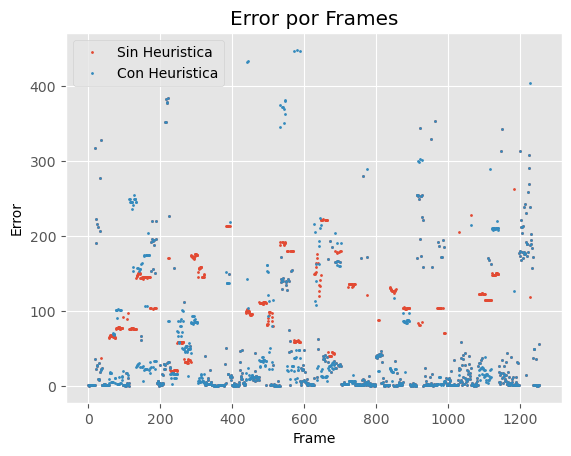

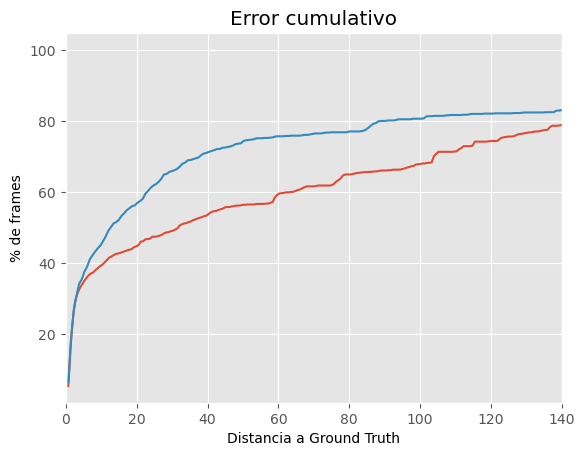

In [256]:
plt.figure()
plt.title("Error por Frames")
plt.xlabel("Frame")
plt.ylabel("Error")
plt.plot(resultado1, 'o', markersize=1, label="Sin Heuristica")
plt.plot(resultado2, 'o', markersize=1, label="Con Heuristica")
plt.legend()

plt.figure()
plt.title("Error cumulativo")
plt.xlabel("Distancia a Ground Truth")
plt.ylabel("% de frames")
plotErrorCumulativo(resultado1, bins=600)
plotErrorCumulativo(resultado2, bins=600)
